# Building a Multi-PDF Agent using Query Pipelines and HyDE

<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/agent/agent_runner/agent_around_query_pipeline_with_HyDE_for_PDFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this example, we show you how to build a multi-PDF agent that can reason across multiple tools, each one corresponding to a RAG pipeline with HyDE over a document.

Author: https://github.com/DoganK01

## **Install Dependencies**

In [ ]:
%pip install llama-index-llms-openai
%pip install llama-index
%pip install pyvis

In [ ]:
%pip install arize-phoenix[evals]

In [ ]:
%pip install llama-index-callbacks-arize-phoenix

## **Download Data and Do Imports**

In [ ]:
!mkdir -p 'data/10k/'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10k/uber_2021.pdf' -O 'data/10k/uber_2021.pdf'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10k/lyft_2021.pdf' -O 'data/10k/lyft_2021.pdf'

In [ ]:
import os

In [ ]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.indices.query.query_transform import HyDEQueryTransform
from llama_index.core.query_engine import TransformQueryEngine
from IPython.display import Markdown, display

In [ ]:
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    StorageContext,
    load_index_from_storage,
)

from llama_index.core.tools import QueryEngineTool, ToolMetadata

# define global callback setting
from llama_index.core.settings import Settings
from llama_index.core.callbacks import CallbackManager

## **Setup Observability**

In [ ]:
callback_manager = CallbackManager()
Settings.callback_manager = callback_manager

In [ ]:
# setup Arize Phoenix for logging/observability
import phoenix as px
import llama_index.core

px.launch_app()
llama_index.core.set_global_handler("arize_phoenix")

In [ ]:
os.environ["OPENAI_API_KEY"] = "sk-"

## **Setup Multi Doc HyDE Query Engine / Tool**

We setup HyDE Query engines and their tools for our multi doc system.

HyDE, short for Hypothetical Document Embeddings, is an innovative retrieval technique aimed at bolstering the efficiency of document retrieval processes. This method operates by crafting a hypothetical document tailored to an incoming query, which is subsequently embedded. The resulting embedding is leveraged to efficiently retrieve real documents exhibiting similarities to the hypothetical counterpart.

In [ ]:
try:
    storage_context = StorageContext.from_defaults(
        persist_dir="./storage/lyft"
    )
    lyft_index = load_index_from_storage(storage_context)

    storage_context = StorageContext.from_defaults(
        persist_dir="./storage/uber"
    )
    uber_index = load_index_from_storage(storage_context)

    index_loaded = True
except:
    index_loaded = False

if not index_loaded:
    # load data
    lyft_docs = SimpleDirectoryReader(
        input_files=["./data/10k/lyft_2021.pdf"]
    ).load_data()
    uber_docs = SimpleDirectoryReader(
        input_files=["./data/10k/uber_2021.pdf"]
    ).load_data()

    # build index
    lyft_index = VectorStoreIndex.from_documents(lyft_docs)
    uber_index = VectorStoreIndex.from_documents(uber_docs)

    # persist index
    lyft_index.storage_context.persist(persist_dir="./storage/lyft")
    uber_index.storage_context.persist(persist_dir="./storage/uber")

In [ ]:
lyft_engine = lyft_index.as_query_engine(similarity_top_k=3)
uber_engine = uber_index.as_query_engine(similarity_top_k=3)


hyde = HyDEQueryTransform(include_original=True)
lyft_hyde_query_engine = TransformQueryEngine(lyft_engine, hyde)
uber_hyde_query_engine = TransformQueryEngine(uber_engine, hyde)

In [ ]:
query_engine_tools = [
    QueryEngineTool(
        query_engine=lyft_hyde_query_engine,
        metadata=ToolMetadata(
            name="lyft_10k",
            description=(
                "Provides information about Lyft financials for year 2021. "
                "Use a detailed plain text question as input to the tool."
            ),
        ),
    ),
    QueryEngineTool(
        query_engine=uber_hyde_query_engine,
        metadata=ToolMetadata(
            name="uber_10k",
            description=(
                "Provides information about Uber financials for year 2021. "
                "Use a detailed plain text question as input to the tool."
            ),
        ),
    ),
]

## **Setup ReAct Agent Pipeline**

### What is ReAct Agent

*  ReAct is a technique that enables LLMs to reason and perform task-specific actions. It combines chain-of-thought reasoning with action planning. It enables LLMs to create reasoning tracks and task-specific actions, strengthening the synergy between them using memory.

* *The ReACT agent model refers to a framework that integrates the reasoning capabilities of LLMs with the ability to take actionable steps, creating a more sophisticated system that can understand and process information, evaluate situations, take appropriate actions, communicate responses, and track ongoing situations.*

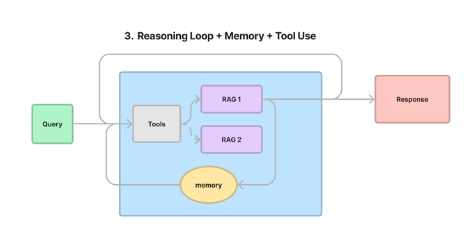

**Reasoning Loop** : The reasoning loop allows data agents to select and interact with tools in response to an input task.

**Memory**: LLMs, with access to memory, can store and retrieve data, ideal for apps tracking state or accessing multiple sources. Memory retains past interactions, enabling seamless reference to earlier conversation points. This integration involves allocating memory slots for relevant information and leveraging retrieval mechanisms during conversations. By recalling stored data, LLMs enhance contextual responses and integrate external sources, enriching user experiences.

# Steps of the ReAct agent we will create

1.   Takes in agent inputs
2.   Calls ReAct prompt using LLM to generate next action/tool (or returns a response).
3. If tool/action is selected, call tool pipeline to execute tool + collect response (In this case, our tools are HyDE Query Engine tools for both documents).
4. If response is generated, get response.



* An `AgentInputComponent `that allows you to convert the agent inputs (Task, state dictionary) into a set of inputs for the query pipeline.

* An `AgentFnComponent`: a general processor that allows you to take in the current Task, state, as well as any arbitrary inputs, and returns an output. In this cookbook we define a function component to format the ReAct prompt. However, you can put this anywhere

Note that any function passed into `AgentFnComponent` and `AgentInputComponent` MUST include task and state as input variables, as these are inputs passed from the agent.

Note that the output of an agentic query pipeline MUST be `Tuple[AgentChatResponse, bool]`.


## Task and State

**Task**: It contains the information required to fulfill the query requested by the user. User input, memory, metadatas, global states over time.


**State**: Some informations like memory


## **Agent Input Component**

Generates inputs for the given task.

In [ ]:
from llama_index.core.agent.react.types import (
    ActionReasoningStep,
    ObservationReasoningStep,
    ResponseReasoningStep,
)
from llama_index.core.agent import Task, AgentChatResponse
from llama_index.core.query_pipeline import (
    AgentInputComponent,
    AgentFnComponent,
    CustomAgentComponent,
    QueryComponent,
    ToolRunnerComponent,
)
from llama_index.core.llms import MessageRole
from typing import Dict, Any, Optional, Tuple, List, cast


## Agent Input Component
## This is the component that produces agent inputs to the rest of the components
## Can also put initialization logic here.
def agent_input_fn(task: Task, state: Dict[str, Any]) -> Dict[str, Any]:
    """Agent input function.

    Returns:
        A Dictionary of output keys and values. If you are specifying
        src_key when defining links between this component and other
        components, make sure the src_key matches the specified output_key.

    """
    # initialize current_reasoning
    if "current_reasoning" not in state:
        state["current_reasoning"] = []
    reasoning_step = ObservationReasoningStep(observation=task.input)
    state["current_reasoning"].append(reasoning_step)
    return {"input": task.input}


agent_input_component = AgentInputComponent(fn=agent_input_fn)

# Define Agent Prompt
Here we define the agent component that generates a ReAct prompt, and after the output is generated from the LLM, parses into a structured object.

After the input is received, LLM is called with the ReAct agent prompt.

`ReActChatFormatter` basically generates a fully formatted react prompt using ReAct Prompting (Chain-Of-Thought + Acting)
 method

In [ ]:
from llama_index.core.agent import ReActChatFormatter
from llama_index.core.query_pipeline import InputComponent, Link
from llama_index.core.llms import ChatMessage
from llama_index.core.tools import BaseTool


## define prompt function
def react_prompt_fn(
    task: Task, state: Dict[str, Any], input: str, tools: List[BaseTool]
) -> List[ChatMessage]:
    # Add input to reasoning
    chat_formatter = ReActChatFormatter()
    return chat_formatter.format(
        tools,
        chat_history=task.memory.get() + state["memory"].get_all(),
        current_reasoning=state["current_reasoning"],
    )


react_prompt_component = AgentFnComponent(
    fn=react_prompt_fn, partial_dict={"tools": query_engine_tools}
)

You can see the ReAct prompt here:

https://github.com/run-llama/llama_index/blob/6cd92affa5835aa21f823ff985a81f006c496bbd/llama-index-core/llama_index/core/agent/react/prompts.py#L6

## **Define Agent Output Parser + Tool Pipeline**
Once the LLM gives an output, we have a decision tree:

1. If an answer is given, then we’re done. Process the output

2. If an action is given, we need to execute the specified tool with the specified args, and then process the output.

Tool calling can be done via the `ToolRunnerComponent` module. This is a simple wrapper module that takes in a list of tools, and can be “executed” with the specified tool name (every tool has a name) and tool action.

We implement this overall module `OutputAgentComponent` that subclasses `CustomAgentComponent`.

`perse_react_output_fn` function simply parses the ReAct prompt got from `react_prompt_fn` into the reasoning step.

In this case, the ReAct Agent choose whatever go with a tool or done with tools and simply gets the output that will be fit in chat response for agents (`AgentChatResponse`).

The `run_tool_fn` function simply runs a tool if it is selected.

Finally, the incoming output is edited in accordance with the Agent output format by applying the `process_agent_response_fn` function.

In [ ]:
from typing import Set, Optional
from llama_index.core.agent.react.output_parser import ReActOutputParser
from llama_index.core.llms import ChatResponse
from llama_index.core.agent.types import Task


def parse_react_output_fn(
    task: Task, state: Dict[str, Any], chat_response: ChatResponse
):
    """Parse ReAct output into a reasoning step."""
    output_parser = ReActOutputParser()
    reasoning_step = output_parser.parse(chat_response.message.content)
    return {"done": reasoning_step.is_done, "reasoning_step": reasoning_step}


parse_react_output = AgentFnComponent(fn=parse_react_output_fn)


def run_tool_fn(
    task: Task, state: Dict[str, Any], reasoning_step: ActionReasoningStep
):
    """Run tool and process tool output."""
    tool_runner_component = ToolRunnerComponent(
        query_engine_tools, callback_manager=task.callback_manager
    )
    tool_output = tool_runner_component.run_component(
        tool_name=reasoning_step.action,
        tool_input=reasoning_step.action_input,
    )
    observation_step = ObservationReasoningStep(observation=str(tool_output))
    state["current_reasoning"].append(observation_step)
    # TODO: get output

    return {"response_str": observation_step.get_content(), "is_done": False}


run_tool = AgentFnComponent(fn=run_tool_fn)


def process_response_fn(
    task: Task, state: Dict[str, Any], response_step: ResponseReasoningStep
):
    """Process response."""
    state["current_reasoning"].append(response_step)
    response_str = response_step.response
    # Now that we're done with this step, put into memory
    state["memory"].put(ChatMessage(content=task.input, role=MessageRole.USER))
    state["memory"].put(
        ChatMessage(content=response_str, role=MessageRole.ASSISTANT)
    )

    return {"response_str": response_str, "is_done": True}


process_response = AgentFnComponent(fn=process_response_fn)


def process_agent_response_fn(
    task: Task, state: Dict[str, Any], response_dict: dict
):
    """Process agent response."""
    return (
        AgentChatResponse(response_dict["response_str"]),
        response_dict["is_done"],
    )


process_agent_response = AgentFnComponent(fn=process_agent_response_fn)

# **Stitch together Agent Query Pipeline**
We can now stitch together the top-level agent pipeline: agent_input -> react_prompt -> llm -> react_output.

The last component is the if-else component that calls sub-components.

In [ ]:
from llama_index.core.query_pipeline import QueryPipeline as QP

qp = QP(verbose=True)

In [ ]:
from llama_index.core.query_pipeline import QueryPipeline as QP
from llama_index.llms.openai import OpenAI

qp.add_modules(
    {
        "agent_input": agent_input_component,
        "react_prompt": react_prompt_component,
        "llm": OpenAI(model="gpt-4-1106-preview"),
        "react_output_parser": parse_react_output,
        "run_tool": run_tool,
        "process_response": process_response,
        "process_agent_response": process_agent_response,
    }
)

In [ ]:
# link input to react prompt to parsed out response (either tool action/input or observation)
qp.add_chain(["agent_input", "react_prompt", "llm", "react_output_parser"])

# add conditional link from react output to tool call (if not done)
qp.add_link(
    "react_output_parser",
    "run_tool",
    condition_fn=lambda x: not x["done"],
    input_fn=lambda x: x["reasoning_step"],
)
# add conditional link from react output to final response processing (if done)
qp.add_link(
    "react_output_parser",
    "process_response",
    condition_fn=lambda x: x["done"],
    input_fn=lambda x: x["reasoning_step"],
)

# whether response processing or tool output processing, add link to final agent response
qp.add_link("process_response", "process_agent_response")
qp.add_link("run_tool", "process_agent_response")

## **Visualize Query Pipeline**

In [ ]:
from pyvis.network import Network

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(qp.clean_dag)
print(net)

{
    "Nodes": [
        "agent_input",
        "react_prompt",
        "llm",
        "react_output_parser",
        "run_tool",
        "process_response",
        "process_agent_response"
    ],
    "Edges": [
        {
            "src_key": null,
            "dest_key": null,
            "condition_fn": null,
            "input_fn": null,
            "width": 1,
            "from": "agent_input",
            "to": "react_prompt",
            "arrows": "to"
        },
        {
            "src_key": null,
            "dest_key": null,
            "condition_fn": null,
            "input_fn": null,
            "width": 1,
            "from": "react_prompt",
            "to": "llm",
            "arrows": "to"
        },
        {
            "src_key": null,
            "dest_key": null,
            "condition_fn": null,
            "input_fn": null,
            "width": 1,
            "from": "llm",
            "to": "react_output_parser",
            "arrows": "to"
        },
    

In [ ]:
# Save the network as "agent_dat.html"
net.write_html("agent_dag.html")

In [ ]:
from IPython.display import display, HTML

# Read the contents of the HTML file
with open("agent_dag.html", "r") as file:
    html_content = file.read()

# Display the HTML content
display(HTML(html_content))

## **Setup Agent Worker around our Query Engines**

In [ ]:
from llama_index.core.agent import QueryPipelineAgentWorker
from llama_index.core.callbacks import CallbackManager

agent_worker = QueryPipelineAgentWorker(qp)
agent = agent_worker.as_agent(
    callback_manager=CallbackManager([]), verbose=True
)

## **Run the Agent**

In [ ]:
# start task
task = agent.create_task(
    "What was Uber's Management's Report on Internal Control over Financial Reporting?"
)

In [ ]:
step_output = agent.run_step(task.task_id)

> Running step 26c623b9-0864-45d9-9f91-f893a4696727. Step input: What was Uber's Management's Report on Internal Control over Financial Reporting?
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='aa7707d1-a35a-4d96-b2cc-ded765a3a3e2' input="What was Uber's Management's Report on Internal Control over Financial Reporting?" memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functool...

> Running module react_prompt with input: 
input: What was Uber's Management's Report on Internal Control over Financial Reporting?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='\nYou are designed to help with a variety of tasks, from answering questions     to providing summaries to other types of analyses.\n\n## Too...

> Runni

In [ ]:
print(step_output)

Observation: {'output': ToolOutput(content="Uber's Management's Report on Internal Control over Financial Reporting stated that they excluded The Drizly Group, Inc. and TupeloParent, Inc. from their assessment of internal control over financial reporting as of December 31, 2021 due to their acquisition by the company during 2021. The report also mentioned that Drizly and TupeloParent were excluded from the audit of internal control over financial reporting.", tool_name='uber_10k', raw_input={'input': "What was Uber's Management's Report on Internal Control over Financial Reporting?"}, raw_output=Response(response="Uber's Management's Report on Internal Control over Financial Reporting stated that they excluded The Drizly Group, Inc. and TupeloParent, Inc. from their assessment of internal control over financial reporting as of December 31, 2021 due to their acquisition by the company during 2021. The report also mentioned that Drizly and TupeloParent were excluded from the audit of int

In [ ]:
# start task
task = agent.create_task("What was Lyft's revenue growth in 2021?")

In [ ]:
step_output = agent.run_step(task.task_id)

> Running step ee9eff5f-a4be-4b76-bae6-d05d2af41ecd. Step input: What was Lyft's revenue growth in 2021?
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='7a038afc-3ead-4b0c-a924-41cd4f465270' input="What was Lyft's revenue growth in 2021?" memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of...

> Running module react_prompt with input: 
input: What was Lyft's revenue growth in 2021?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='\nYou are designed to help with a variety of tasks, from answering questions     to providing summaries to other types of analyses.\n\n## Too...

> Running module react_output_parser with input: 
chat_response: assistant: Thought: I need

In [ ]:
step_output = agent.run_step(task.task_id)

> Running step 279c7a46-ce9d-4202-bec4-01d5c1ed50bd. Step input: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='7a038afc-3ead-4b0c-a924-41cd4f465270' input="What was Lyft's revenue growth in 2021?" memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of...

> Running module react_prompt with input: 
input: What was Lyft's revenue growth in 2021?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='\nYou are designed to help with a variety of tasks, from answering questions     to providing summaries to other types of analyses.\n\n## Too...

> Running module react_output_parser with input: 
chat_response: assistant: Thought: The user has repeated the question, but t

In [ ]:
step_output.is_last

True

In [ ]:
print(step_output)

Uber's Management's Report on Internal Control over Financial Reporting for the year ended December 31, 2021, stated that management excluded The Drizly Group, Inc. ("Drizly") and TupeloParent, Inc. ("Transplace") from its assessment of internal control over financial reporting. This exclusion was due to their acquisition by the company during 2021. Drizly and Transplace were wholly-owned subsidiaries whose total assets and total revenues collectively represented approximately 3% and 4%, respectively, of the related consolidated financial statement amounts for the year.


In [ ]:
response = agent.finalize_response(task.task_id)

In [ ]:
print(str(response))

Uber's Management's Report on Internal Control over Financial Reporting for the year ended December 31, 2021, stated that management excluded The Drizly Group, Inc. ("Drizly") and TupeloParent, Inc. ("Transplace") from its assessment of internal control over financial reporting. This exclusion was due to their acquisition by the company during 2021. Drizly and Transplace were wholly-owned subsidiaries whose total assets and total revenues collectively represented approximately 3% and 4%, respectively, of the related consolidated financial statement amounts for the year.
